## Description:
######Model type = RNN
######Hidden layers = 128*2
######train seq_len = 200
######model id = rnn128-200
######model_name feature and printing more
######want to try epoch down and batch size down, but should keep same for experiment between LSTM and RMM
chars = sorted(list(set(text)))

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

Google Colab Mounting

In [12]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Hyper Params

In [24]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
cell_type = "rnn"
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = 'new-' + cell_type + str(hidden_size) + '-' + str(seq_len) #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"
print(model_id)

new-rnn128-200


Data Loading

In [14]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = sorted(list(set(text))) #set will not be the same every time, which cause loss of model before new-rnn-128-200
tchars = sorted(list(set(test_text)))
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))
print(chars)

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Data Preprocessing

In [15]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)

    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [20]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=2, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.020250000059604645
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
lr
QQAgrx,A&E;Sn;WQ:$srWULx&ElfS[n.IccSSx;SErItn;n SCO [cxP;WFlWQxnfSmOWBSxPgSBExWdnY W3nGnSZJBnf3lu iSxc3Atnx3hxWc;Sxn;c;un[[xEEGS&nxaLaUOW;nAIOqxn-SPP&[cfnDHnn nfI?SSSA;nGSnZx3WcaA& n;unWLau?SSWfLx&
test generate with forwardc
JulietPxnISjfxK]p3lIJc?LPxnqjSjnn; nn;S$p3MDB[SsxMnn;S&3aISjf[aAlC]m]
S:-?v SLnnnmSxQOWSraZ3;:xGCnc; nn;SS3aISjxWSu-H BaIJWSLRnqjnn;uxnn; nnnnnn$ nn; n?Oxsx 

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([

Build new model

In [27]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2) #omg
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new {}-{} model named {} and record named {} initted".format(cell_type, hidden_size, model_id, rec_name))

new rnn-128 model named new-rnn128-200 and record named rec-new-rnn128-200.pkl initted


Or Load saved model

In [0]:
if LOAD:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    model.load_state_dict(torch.load(model_path+load_model_name, map_location=lambda storage, loc: storage)['model'])
    #print(torch.load(model_path+load_model_name)['model'])
    model.eval() #important
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


Train

In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [31]:
if not LOAD:
    train()

  0%|          | 0/432 [00:00<?, ?it/s, loss=2.532, test_ac=0.313, train_ac=0.308]


At 1 epoche, loss = 3.119, train ac = 0.208, test ac = 0.208
RNN write with seed Juliet

##############################

Juliet, fee tila yomey, snod anty that ilos th ichinl there brame.

I$LRA:Rkl Toung  ahice the pille he to ghe siln eer :ond anf hh loe moug. Aob
bure toe i

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
i ENIhE::E:
I  ter neto the tou  tn toue  toet tn  
hne te tree   tn tn  thet  tore  n n   
he tneer n  tet tonh    tnd touton 

het toeetn tnetn  wn tet tnto n  tote 

h tn tote tn   te trtetote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.352, test_ac=0.371, train_ac=0.343]


At 2 epoche, loss = 2.410, train ac = 0.332, test ac = 0.337
RNN write with seed Juliet

##############################

Juliet, and mpand grurwert pathill of mowour wigs afere, or mobuf freoses,, wart me and thime
yand gisting ood her sithe out bange the for not youly fhat ha

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::IRI::::
A  testnhte the torn tf toue  toat tn  Tote te trte t af tn  thet  toreern ng  The tneer nh ten tonh rd tnd to totn

het toeetn tnetn  In tet tnto n  torl 
To tn tote tfd  te trtetote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.133, test_ac=0.389, train_ac=0.385]


At 3 epoche, loss = 2.255, train ac = 0.363, test ac = 0.378
RNN write with seed Juliet

##############################

Juliet in stour undaning you cainhe
gut fore to overs you on the that the wiml come toon mes it sound, in bdot'll spor e fore, frather pall head:
Srallle,
W

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::IN::N::
T  tastnhte the tord tf tore  trat tf  Aote te tnte t tf tn  thet  threern ng  The tnler nh ten tonh r  tnd to totn

het toaetngtnetng
In tet tnto ng torl 
T  tn tote tfd  te tnretote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.084, test_ac=0.399, train_ac=0.400]


At 4 epoche, loss = 2.141, train ac = 0.385, test ac = 0.398
RNN write with seed Juliet

##############################

Julietse
Af and thou merqut pheres, the lick me pronich's thou shar the mather at-stand's ams montert,
That yea now and me cor'll heare fir tome will, of le

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN::N::
T  tastnete the tord tf tore  trat tf  Aote te tntent tf tn  thet  thr ern ng  Ahe snler nh ten tonh r  tnd to tosn

het thaetngtnetn 
In tet tnto ng torl  T  tn tone tfd  te tnretose the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 57.78it/s, loss=2.020, test_ac=0.416, train_ac=0.407]


At 5 epoche, loss = 2.064, train ac = 0.402, test ac = 0.406
RNN write with seed Juliet

##############################

Juliet the ore our theast is giod thut me and hes, cearsut gome, I me the metien fordrapend,
Thas and be forzus grollome this dingir you stoagers seed uss-n

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:ANE:
W  tystnete the sord tf tove  trat tf  Aote te tntent tf tn  ahet  thrsernheg  Ahe snler nh ten tonh r  tnd th toss

het thaenngtnenn 
In tev tnto ng torl  T  tn tone tfsr te tnrttoge the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.003, test_ac=0.427, train_ac=0.408]


At 6 epoche, loss = 2.031, train ac = 0.410, test ac = 0.420
RNN write with seed Juliet

##############################

Julietong to so, ald my bringt then him the gove him.

Firs my of is dence, frie gingly
grouthy.

SVINIES:
Yecen to mare!
Lere and's ley stangs but had cone

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:AOA:
I  tystnete the sord tf tove  trat tf  Aode te tntontetf tn  thet  thrsern og  Ahe snler oh ten thnh r  tnd th toss

het thaenngtnenn 
In tev tnso ng torl  T  tn tone tfsr te tnrttove the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 58.59it/s, loss=1.983, test_ac=0.438, train_ac=0.421]


At 7 epoche, loss = 1.980, train ac = 0.420, test ac = 0.427
RNN write with seed Juliet

##############################

Julietly theur me, were ey, thears have it not as of with mere surad.

LAROL:
He lord sich vsean doon
The tire have an copcelton the mistrees, I might sice.

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:AAA:
W  tystnete the sord tf tive  trat tf  Aode te tntontetf tn  thet  threern og  Ahe snper oh ten thnh r  tnd th toss

het thaonn tnein 
In tev tnso ng torl  T  tn tone tf r te tnrttove the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 58.86it/s, loss=1.879, test_ac=0.424, train_ac=0.443]


At 8 epoche, loss = 1.968, train ac = 0.423, test ac = 0.432
RNN write with seed Juliet

##############################

Juliet might
What with a tought in the faint opar in prays and the
mortenter.

IONl whis I saich the your then of even and'st the
ripen, and's mush usoresti

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:IAE:
I  tystnete the sard tf tive  tray tf  Aode te tntontetf tn  ahet  thrsern og  The snper oe ten tore d  tnd th tos 

het thaonn tnein 
In tev tnso ng torl  Tf tn tone tf r ty tnrttove the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.897, test_ac=0.445, train_ac=0.433]


At 9 epoche, loss = 1.920, train ac = 0.435, test ac = 0.439
RNN write with seed Juliet

##############################

Juliet: his not we well. The do the nesend fay worl the corno of net it wation lord:
Tree, buse, him; combinour the say hand, why not cray,
'st in he plapen

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:TOE:
I  tystnete the sarl tf tive  tray tf  Aode te tntontetf tn  ahet  thrsern og  Ahe snper oe ten tore d  tnd th toss

het thaonn tnein 
In tev t so ng torl  T  tn tone tf r te tnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.909, test_ac=0.441, train_ac=0.444]


At 10 epoche, loss = 1.891, train ac = 0.440, test ac = 0.441
RNN write with seed Juliet

##############################

Juliet meer strince,
And tuin her and at thou time tried.

HAMION:
O, And I so comes of her the can his amond, and wold it know charce my time hearteny the 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:TAE:
I  tystnete the sarl tf tive  aray tf  Aode te tntontetf ts  ahet  ahreern og  Ahe srper oe ten thrk d  tnd th tes 

het thaonn tnein 
In tev t we ng torl  Tf tn tone tf r ty tnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 58.36it/s, loss=1.824, test_ac=0.431, train_ac=0.458]


At 11 epoche, loss = 1.903, train ac = 0.442, test ac = 0.448
RNN write with seed Juliet

##############################

Juliet piry,
Thhermain to where the fiar to untershonesten sauned.

GONTANUS:
Halt to shall the though the wordss mavery hims if the sey where of Shack bloo

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::IN:TAE:
I  tystnete the sarl tf tive  tray tf  Aove te tntontetf tt  ahet  threern og  Ahe srpea oedten thrk d  tnd th tes 

het thaonn tnein 
In tev t se ng torl  T  tn tone tf r te tnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.872, test_ac=0.434, train_ac=0.445]


At 12 epoche, loss = 1.879, train ac = 0.449, test ac = 0.450
RNN write with seed Juliet

##############################

Julieties is our in my instold mafts but to death
The brom be reveron hit peak the look of fether that with havep the shall in to diswither then the shemed,

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::IF:TAE:
I  tystnete the sarl tf tive  aray tf  Aove te tntontetf ts  ahet  ahreern og  Ahe srpea oedten thrk d  tnd th ted 

het thaonn tnain 
In tev t se ng torl 
T  tn tone tf r te lnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 57.39it/s, loss=1.834, test_ac=0.456, train_ac=0.451]


At 13 epoche, loss = 1.867, train ac = 0.449, test ac = 0.451
RNN write with seed Juliet

##############################

Juliet,
More give as for that you where 'trought I but not wellies on a strames trow to the world catI sow the whot grace suep, fear shall of this crown seo

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::IF:TAA:
I  tystnete the sarl tf tive  tray tf  Aove te tntontetf ts  ahet  thrsern og  The srpea oydten tork d  tnd th ted 

het thaonn tnain 
In tev t se ng torl 
Tf tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.875, test_ac=0.461, train_ac=0.455]


At 14 epoche, loss = 1.835, train ac = 0.456, test ac = 0.460
RNN write with seed Juliet

##############################

Julieter and us hath,
And then ithanded she plain your this deart blood of as goan: beather know thou not ungirst be conseath, there the know the' go the fo

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::SF:TAE:
I  tystnete the sarl tf tire  aray tf  Aove te tntonteaf ts  ahet  ahreorn og  Ahe srpea oydten tork d  and th sed 

het thaonn tnain 
In tev t se ng torl 
T  tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.780, test_ac=0.456, train_ac=0.468]


At 15 epoche, loss = 1.859, train ac = 0.450, test ac = 0.460
RNN write with seed Juliet

##############################

Juliet my bind, than sid to sow the plogid repost more?

WOLEY:
I dave on palts, you, mease.

CLEMANO:
Sore well, aid have drey sa hingly her wet you war re

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::IF:TAE:
I  tystnete the sarl tf tive  aray tf  Aove te tntenteaf ts  ahet  ahreern og  Ahe srpea oydten tork d  and th sed 

het thaonn tnain 
In tev t se ng torl 
T  tn tone tf r te lnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 58.56it/s, loss=1.809, test_ac=0.471, train_ac=0.460]


At 16 epoche, loss = 1.816, train ac = 0.458, test ac = 0.462
RNN write with seed Juliet

##############################

Julieter thought he neath a nof heir that to mone himble as shames good pospuries a thind, I will strays for the time? I love will be it Depcals you concent

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::HF TAE:
I  tystnete the sarl tf tire  aray tf  Aove te tncenteaf ts  ahet  ahreorn og  Ahe srpea oydten thrk d  and th sed 

het thaonn tnain 
In tev t se ng torl 
Af tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.781, test_ac=0.476, train_ac=0.472]


At 17 epoche, loss = 1.840, train ac = 0.449, test ac = 0.461
RNN write with seed Juliet

##############################

Juliet I that that so are,
What send ever I for you thou mand speaks if a proce?

LIMENIUS:
Varrising her have say you.

DUCENES:
For no thine wad, them not

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::VF:TAE:
I  tystnete the sarl tf tive  aray tf  Aove te tncenteaf tt  ahet  threorn og  Ahe srpea oydten tork d  and th sed 

het thaonn tnain 
In tev t se ng torl 
A  tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.814, test_ac=0.468, train_ac=0.471]


At 18 epoche, loss = 1.821, train ac = 0.463, test ac = 0.470
RNN write with seed Juliet

##############################

Julietenwert all reward of my for to sengers, come nom where's shalon, ever in with men the with a duged weal's his on'e
Montay say, were now you are not ho

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::VF TAA:
I  tystnete the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threorn og  Ahe srpea oydten tork d  and th sed 

het thaonn tnain 
In tev t se ng totl 
T  tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.799, test_ac=0.469, train_ac=0.469]


At 19 epoche, loss = 1.820, train ac = 0.463, test ac = 0.472
RNN write with seed Juliet

##############################

Juliet in my and forget to more do to my pichers wellow of seever off? the lany fry hour deedy, soul sound are ithand it fail fit a thust the dament.

IOGEL

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
iS::VF TAA:
I  tystnete the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threorn og  Ahe srpea oydten tork d  and th sed 

het thaonn tnain 
In tev t se ng totl 
T  tn tone tf r te lnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 58.31it/s, loss=1.859, test_ac=0.471, train_ac=0.465]


At 20 epoche, loss = 1.800, train ac = 0.469, test ac = 0.470
RNN write with seed Juliet

##############################

Juliet him.-
Let this withher than for it your this lieg
Mence, and harm,
But I she not that be and I
as a reponcomy then madam, of hose beriled the toor me

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threort og  Ahe srpea oydten tork d  and th sod 

het thaong tnain 
In tev t se ng torl 
A  tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.805, test_ac=0.485, train_ac=0.464]


At 21 epoche, loss = 1.796, train ac = 0.466, test ac = 0.467
RNN write with seed Juliet

##############################

Juliet of house and by the great in be that greest me your full the will not my such with a centimber a make and servast no life?

MONTIO:
Respeak and the s

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAE:
I  tystnete the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threort og  Ahe srpeatoydten thrk d  and th sod 

het shaann tnain 
In tev t se ng totl 
T  tn tone tf r te lnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 57.13it/s, loss=1.758, test_ac=0.489, train_ac=0.474]


At 22 epoche, loss = 1.818, train ac = 0.463, test ac = 0.483
RNN write with seed Juliet

##############################

Juliet of wind with at the fuccheld like
To for lord,
And speak.

MIRDIUS:
What so,
Why, and do the how crope but tiem, confort, that, not part the ow the r

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threolt og  Ahe srpea oydten tork d  and th sed 

het thaang tnain 
In tev t se ng totl 
T  tn tone tf r te lnrttike the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 54.25it/s, loss=1.765, test_ac=0.466, train_ac=0.473]


At 23 epoche, loss = 1.769, train ac = 0.479, test ac = 0.479
RNN write with seed Juliet

##############################

Julieted which him, in this now his rucks
Which a destrayon.

FLONCIO:
Well is in your hanger me that lives with the some complain with shissing of not scac

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threolt og  Ahe srpeatoydten tork d  and th sod 

het thaang tnain 
In tev t me ng totl 
T  tn tone tf r te lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.772, test_ac=0.478, train_ac=0.483]


At 24 epoche, loss = 1.728, train ac = 0.488, test ac = 0.477
RNN write with seed Juliet

##############################

Juliet it horself of man I ho
Mighthis,
To amester, burn in of the come whose are say me so not her is then igenthe,
Come;
Where we south one both great wit

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threorthog  Ahe srpea oydten thrk d  and th sod 

het shaang tnain 
In tev t me ng totl 
T  tn tone tf r te lnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 56.04it/s, loss=1.756, test_ac=0.473, train_ac=0.481]


At 25 epoche, loss = 1.774, train ac = 0.472, test ac = 0.484
RNN write with seed Juliet

##############################

Julieten, rance in But dood here father shreek so dost for his make the madam?

AFILEN:
At the bear a charly moor'd time with the marry and wift the like hi

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenseaf tt  ahet  threort og  Ahe srpeatoydten tork d  and th sod 

het thaann tnains
In tev t me ng totl 
T  tn tone tf r te lnrttoke the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 56.02it/s, loss=1.810, test_ac=0.490, train_ac=0.456]


At 26 epoche, loss = 1.730, train ac = 0.490, test ac = 0.478
RNN write with seed Juliet

##############################

Julieter my longer of the cruen of more my life, for that, for the say, see not or me of the singuatt. Mest, and her from the both the delo,
Wall with of no

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threolthog  Ahe srpeatoydten thrk d  and th sod 

het shaang tnains
In tev t me ng totl 
T  tn tone tf r te lnrttike the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.741, test_ac=0.485, train_ac=0.495]


At 27 epoche, loss = 1.818, train ac = 0.461, test ac = 0.492
RNN write with seed Juliet

##############################

Juliet:
But you like him.

SABESPE:
Whither not,
My ling haid?

BRINCLAC:
My lord, at thinks shar they shall fent us; and wands in with him with Lord, perac

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threolt og  Ahe srpeatoydten thrk d  and th sed 

het shaang tnain 
In tev t me ng totl 
T  tn tone tf r te lnrttike the 

##############################



  1%|▏         | 6/432 [00:00<00:07, 57.50it/s, loss=1.749, test_ac=0.480, train_ac=0.474]


At 28 epoche, loss = 1.758, train ac = 0.480, test ac = 0.486
RNN write with seed Juliet

##############################

Juliet;
If I was the seading this doth is flieve in the head enemy greatong him.

CORUCEAL:
I know you,
Alo, I that in the sonvercains took a peald this fea

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenteaf tt  ahet  threort og  Ahe srpeatoydten thrk d  tnd th sed 

het shaang tnains
In tev t me ng totl 
T  tn tone tf r te lnrttike the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.748, test_ac=0.493, train_ac=0.478]


At 29 epoche, loss = 1.767, train ac = 0.478, test ac = 0.487
RNN write with seed Juliet

##############################

Juliet loir as the heart; and their shall lord for my with the cannot hast thines,
In you! I could the unterming your doth mistrem
What would be uses on the

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncenseaf tt  ahet  threolt og  Ahe srpeatoydten thrk d  tnd th sod 

het whaang tnains
If tev t me ng totl  Tf tn tone tf r te lnrttoke the 

##############################



100%|██████████| 432/432 [00:07<00:00, 60.62it/s, loss=1.675, test_ac=0.481, train_ac=0.494]



At 30 epoche, loss = 1.728, train ac = 0.485, test ac = 0.485
RNN write with seed Juliet

##############################

Juliet his great offer, lighter in the haughter man
S, art of the fall a man us my lords, a muck so this reating that I will speak thee, so brother earth'd 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
RS::VF TAA:
I  tystnhte the sarl tf tive  arac tf  Aove te tncelseaf tt  ahet  threolt og  Ahe srpeatoydten thrk d  tnd th sed 

het shaang tnains
af tev t me ng totl 
T  tn tone tf r ty lnrttike the 

##############################

Tranning records saved to disk.


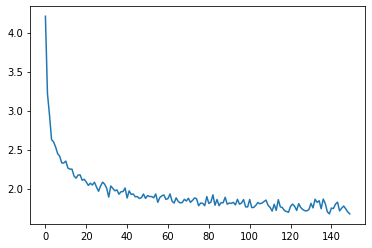

In [32]:
plt.figure()
plt.plot(record['loss'])
plt.show()

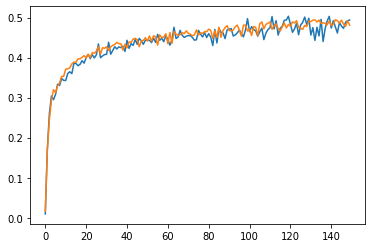

In [33]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [46]:
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
print(calc_accuracy(model, train_data, n_batch=len(train_data)-1, device=device))

0.48853808641433716
0.49970442056655884


In [35]:
print(generate(model, device)) #default tau = 0.8

Juliet pase before heaver when shall furace from the king without undly upon's head,
And, and to you heaven cainter.

HANTIO:
Bather ment the grees a did hi


In [36]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

juliet the sent the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the s 

juliet?
AX ?,
Combre interdor's
insetaje.
Y: tomptme, noq as Lold.

IUKI S ooch ThoBe Loas.
Ningtcr!
Qie-d; iqorign,
Leabsl'g.

COOFrUdS:
Valvictafui
ulf re 



In [37]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') 

i will upon it my tramed my bastied to be's being the would it you.

Second Hother lawful at on my gold, this to heard a doth a death, thou was, make the bring to not where you do a mantit,
And the chasceing is say hearts this bound a thing by Great the danger'd and have out my of untenting is says the tame and one pact his buse:
Go mion my lost's aponeranted of you to the duke me is not there as be, like not, vortule
Where is that have honour thy fairs of gravicy father and daughter with a grace
As n 



In [38]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
rnst tatisen 
Tu ore ti wroveed tnd tarther  ae r te toeak 

CNl 
Iieak  tieak 

Cirst Cltisen 
Tou sre t l testldes tether th tes thet th toienh 

CNl 
Teatmdes 
Teseldes 

Cirst Cltisen 
Torst  tou 


In [39]:
seeds = ["I", "Juliet", "KING:", "my lord", "flower", "soldier", "my son", "father", "hope", "death"]
for seed in seeds:
    print("------------seed: {}-----------".format(seed))
    print(generate(model, device, seed=seed, predict_len=500, tau=0.8))

------------seed: I-----------
I was him for a glack,
That is the show the mair of this grace of blooder tongue,
My serve for
Our with the byous. I lad I have love.

EARLINE:
I will that it my, and the head are is the dead doth the bold worther'd on ranes, and sing place my surited and proffers and to but daught creasong is't to me thou for your better.

GORATUS:
A man of his fear;
they reemy sair more
To down the commin you have was her good sight but my soul bounds warnt thought. Sir, for here for his pripe.

HORTENLIO:
Who 
------------seed: Juliet-----------
Juliet.

GLENTING:
No soldied to the evers ade capting dissucderil, hands, and shall you the soldied their dissent some than this of Andit; low the batter womed see out count too mosir stand, and line.

First garfert thou of the cray.

NERICO:
She have I have sube good of hell;
What,
Are eyes;
These words to see now have our gold in me the porel'dions
And his distless more place quiers and with now? be in the are of with the pr